<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#функция-для-кросс-валидации" data-toc-modified-id="функция-для-кросс-валидации-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>функция для кросс-валидации</a></span></li><li><span><a href="#функция-без-кросс-валидации" data-toc-modified-id="функция-без-кросс-валидации-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>функция без кросс-валидации</a></span></li><li><span><a href="#CountVectorizer" data-toc-modified-id="CountVectorizer-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>CountVectorizer</a></span></li><li><span><a href="#TfidfVectorizer" data-toc-modified-id="TfidfVectorizer-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>TfidfVectorizer</a></span></li><li><span><a href="#DistilBERT" data-toc-modified-id="DistilBERT-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>DistilBERT</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Тестирование-лучшей-модели" data-toc-modified-id="Тестирование-лучшей-модели-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Тестирование лучшей модели</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

Нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 


----
# Подготовка

----

In [1]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import statsmodels.api as sm
import transformers as ppb
from tqdm import notebook 
import seaborn as sns
import pandas as pd
import transformers
import numpy as np
import torch
import re


import spacy
# spacy.load('en_core_web_sm')
# Загрузка модели spaCy
nlp = spacy.load('en_core_web_sm')
stopwords = list(nlp.Defaults.stop_words)

# import nltk
# nltk.download('omw-1.4')
# from nltk.corpus import stopwords as nltk_stopwords
# from nltk.corpus import wordnet as wn
# from nltk.stem import WordNetLemmatizer
# from nltk.tokenize import TweetTokenizer
# nltk.download('wordnet')
# nltk.download('stopwords')
# nltk.download('punkt')
# stopwords = set(nltk_stopwords.words('english'))

import requests
from tqdm import tqdm
tqdm.pandas()
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)


from sklearn.metrics import roc_auc_score, f1_score, recall_score, roc_curve, precision_score, confusion_matrix, precision_recall_curve
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn import metrics 

RANDOM_STATE= 4321

INFO: Pandarallel will run on 2 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [2]:
data = pd.read_csv('.\\data\\toxic_comments.csv')
data.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [3]:
def df_info(df):
    df.info()
    print('-----------')
    print('размер датафрейма', df.shape)
    print('Количество дубликатов:', df.duplicated().sum())
    print('-----------')
    print('Количество пропусков:') 
    print(df.isna().sum())
    print(df['toxic'].value_counts().plot(kind='bar'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB
-----------
размер датафрейма (159292, 3)
Количество дубликатов: 0
-----------
Количество пропусков:
Unnamed: 0    0
text          0
toxic         0
dtype: int64
Axes(0.125,0.11;0.775x0.77)


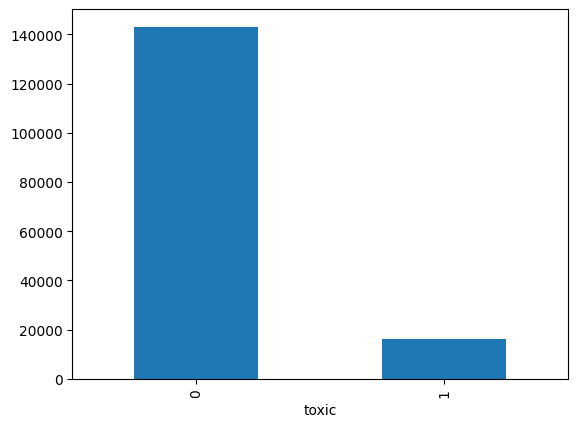

In [4]:
df_info(data)

In [5]:
# удаляем неинформативный столбец
data = data.drop(['Unnamed: 0'], axis=1)
data.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


Наблюдается большой дисбаланс классов

----
# Обучение

----

[тык](https://habr.com/ru/post/503420/)

In [6]:
# уберем заранее спецсимволы 
def clean_text(text):
    text = re.sub(r'[^a-zA-Z ]', ' ', text) # оставляем только латинские буквы
    text = text.lower()  
    return ' '.join(text.split())

In [7]:
data['text_clean'] = data['text'].apply(clean_text)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   text        159292 non-null  object
 1   toxic       159292 non-null  int64 
 2   text_clean  159292 non-null  object
dtypes: int64(1), object(2)
memory usage: 3.6+ MB


In [9]:
# правильно выбираем лемматизатор
# перестал работать
# word_net_lemm = WordNetLemmatizer()
# def lemmatize(text):
#     word_list = nltk.word_tokenize(text)
#     return ' '.join([word_net_lemm.lemmatize(w) for w in word_list])


# Определение функции для лемматизации текста
def spacy_lemmatize(text):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc])

In [10]:
%%time
data['lemm_text'] = data['text_clean'].progress_apply(spacy_lemmatize)

100%|██████████| 159292/159292 [48:03<00:00, 55.23it/s]  


CPU times: total: 36min 42s
Wall time: 48min 5s


In [11]:
data

,text,toxic,text_clean,lemm_text
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits made under my userna...,explanation why the edit make under my usernam...
1,D'aww! He matches this background colour I'm s...,0,d aww he matches this background colour i m se...,d aww he match this background colour I m seem...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man i m really not trying to edit war it s...,hey man I m really not try to edit war it s ju...
3,"""\nMore\nI can't make any real suggestions on ...",0,more i can t make any real suggestions on impr...,more I can t make any real suggestion on impro...
4,"You, sir, are my hero. Any chance you remember...",0,you sir are my hero any chance you remember wh...,you sir be my hero any chance you remember wha...
...,...,...,...,...
159287,""":::::And for the second time of asking, when ...",0,and for the second time of asking when your vi...,and for the second time of ask when your view ...
159288,You should be ashamed of yourself \n\nThat is ...,0,you should be ashamed of yourself that is a ho...,you should be ashamed of yourself that be a ho...
159289,"Spitzer \n\nUmm, theres no actual article for ...",0,spitzer umm theres no actual article for prost...,spitzer umm there s no actual article for pros...
159290,And it looks like it was actually you who put ...,0,and it looks like it was actually you who put ...,and it look like it be actually you who put on...


Статья про лемматизаторы: https://webdevblog.ru/podhody-lemmatizacii-s-primerami-v-python/

In [12]:
# сохраним таблицу
#data.to_csv('.\\data\\table_for_project.csv')

In [13]:
# разделим данные 3:1:1
features_train, features_valid, target_train, target_valid = train_test_split(data['lemm_text'], 
                                                                              data['toxic'], 
                                                                              test_size = 0.4, 
                                                                              random_state = RANDOM_STATE)

features_valid, features_test, target_valid, target_test = train_test_split(features_valid, 
                                                                            target_valid, 
                                                                            test_size = 0.5,
                                                                            random_state = RANDOM_STATE)

----

## функция для кросс-валидации

----

In [14]:
# ниже будет пример с применением pipeline
# cv
def grid_cv(model, param_grid, x_train, y_train, x_valid, y_valid):
    print('____')
    print('f1')
    print('____')
    grid_f1 = GridSearchCV(
        model,
        param_grid = param_grid,
        scoring='f1', 
        n_jobs= -1,
        cv = 3) # так как мы разделяли на 3 выборки, то сделем cv меньше
    grid_f1.fit(x_train, y_train)
    
    print('|best f1|:', grid_f1.best_score_) # лучшее значение f1 на кросс-валидации
    print('|best params_f1|:', grid_f1.best_params_)  # лучшие гиперпараметры
    print('|best_fit_time_f1|:', grid_f1.refit_time_) # время лучшей модели на fit
    
    cv_result_best_f1 = pd.DataFrame(grid_f1.cv_results_).iloc[grid_f1.best_index_] # здесь хранится таблица со всеми лучшими результатами grid`а
    print('|best_time_predict_f1|:', cv_result_best_f1['mean_score_time']) # время лучшей модели на predict()
    
    print('-------------------------------------------------------')
    
    print('_________')
    print('roc_auc')
    print('_________')
    grid_roc_auc = GridSearchCV(
        model,
        param_grid = param_grid,
        scoring='roc_auc',  # учитываем несбалансированность классов и используем ovr, так как он чувствителен к дисбалансу
        n_jobs= -1,
        cv = 3) # так как мы разделяли на 3 выборки, то сделем cv меньше
    grid_roc_auc.fit(x_train, y_train)
    
    
    predictions = grid_roc_auc.predict(x_valid)
    probabilities = grid_roc_auc.predict_proba(x_valid)
    probabilities_one = probabilities[:, 1]
    fpr, tpr, thresholds = roc_curve(y_valid, probabilities_one)
    plt.figure()
    # ROC-кривая случайной модели (выглядит как прямая)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(fpr,tpr)
    plt.xlim([0.0, 1.0]) # устанавливаем границы осей от 0 до 1
    plt.ylim([0.0, 1.0]) # устанавливаем границы осей от 0 до 1
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая модели на cv')
    plt.show()
    
    
    confusion_matrix = metrics.confusion_matrix(y_valid, predictions) # Матрица предсказаний
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True]) 
    cm_display.plot()
    plt.show() 
    
    print('|best_roc_auc|:', grid_roc_auc.best_score_) # значение roc-auc на cv
   
    return grid_f1.best_score_, grid_f1.refit_time_, cv_result_best_f1['mean_score_time'], grid_roc_auc.best_score_

----

## функция без кросс-валидации

---

In [15]:
# без cv
def model_not_cv(model, x_train, y_train, x_valid, y_valid):
    
    model.fit(x_train, y_train)
    predictions_valid = model.predict(x_valid)
    
    probabilities_valid = model.predict_proba(x_valid)
    probabilities_one_valid = probabilities_valid[:, 1]

    auc_roc = roc_auc_score(y_valid, probabilities_one_valid)

    precision, recall, thresholds = precision_recall_curve(y_valid, probabilities_one_valid)
    fpr, tpr, thresholds = roc_curve(y_valid, probabilities_one_valid)
    plt.figure()

    # ROC-кривая случайной модели (выглядит как прямая)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(fpr,tpr)
    plt.xlim([0.0, 1.0]) # устанавливаем границы осей от 0 до 1
    plt.ylim([0.0, 1.0]) # устанавливаем границы осей от 0 до 1

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая модели без cv')

    plt.show()
    
    confusion_matrix = metrics.confusion_matrix(y_valid, predictions_valid) # Матрица предсказаний
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True]) 
    cm_display.plot()
    plt.show()
    
    print('f1 модели без cv:', f1_score(y_valid, predictions_valid))
    print('ROC-AUC без cv:', auc_roc)
    print('recall без cv:', recall_score(y_valid, predictions_valid))
    print('precision без cv:', precision_score(y_valid, predictions_valid))
    
    return  f1_score(y_valid, predictions_valid) , auc_roc

----
## CountVectorizer

----

In [16]:
count_vect = CountVectorizer(stop_words = stopwords)
n_gramm_train = count_vect.fit_transform(features_train) #обучаем только на трейне
n_gramm_valid = count_vect.transform(features_valid)
n_gramm_test = count_vect.transform(features_test)


print('размер n-граммы на train:', n_gramm_train.shape)
print('размер n-граммы на valid:', n_gramm_valid.shape)
print('размер n-граммы на test:', n_gramm_test.shape)

размер n-граммы на train: (95575, 111342)
размер n-граммы на valid: (31858, 111342)
размер n-граммы на test: (31859, 111342)


____
f1
____
|best f1|: 0.7552412086493869
|best params_f1|: {}
|best_fit_time_f1|: 3.790707588195801
|best_time_predict_f1|: 0.03449567159016927
-------------------------------------------------------
_________
roc_auc
_________


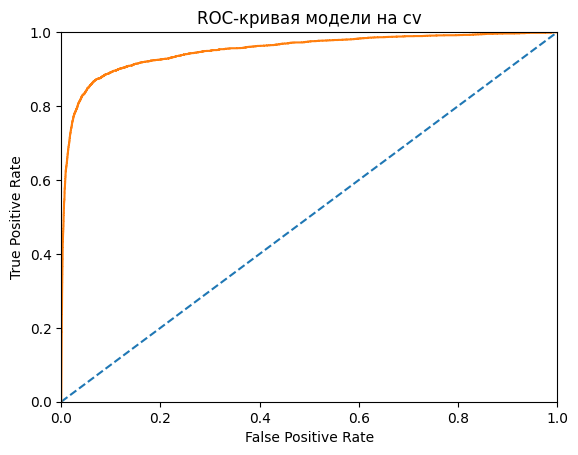

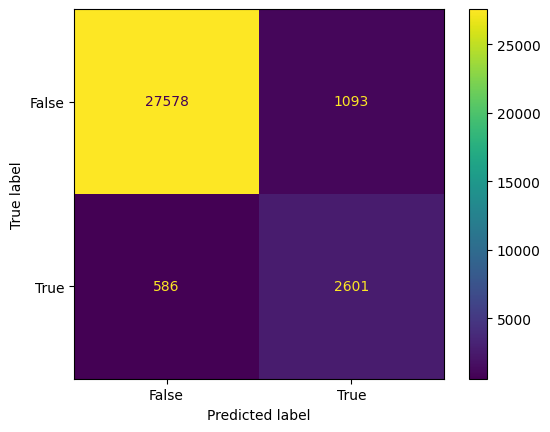

|best_roc_auc|: 0.9477703251748308
CPU times: total: 9.55 s
Wall time: 41.4 s


In [17]:
%%time
# cv
lr_count_cv = LogisticRegression(random_state = RANDOM_STATE, class_weight='balanced')
param_lr_count_cv = {}
lr_count_cv_f1, lr_fit_time_count_cv_f1, lr_predict_time_count_cv_f1, lr_count_cv_roc_auc = grid_cv(lr_count_cv, 
                                                                                                    param_lr_count_cv,
                                                                                                    n_gramm_train,
                                                                                                    target_train,
                                                                                                    n_gramm_valid,
                                                                                                    target_valid)

____
f1
____
|best f1|: 0.7054803837566964
|best params_f1|: {'eta0': 0.01, 'learning_rate': 'optimal', 'max_iter': 7}
|best_fit_time_f1|: 0.5493886470794678
|best_time_predict_f1|: 0.05216113726298014
-------------------------------------------------------
_________
roc_auc
_________


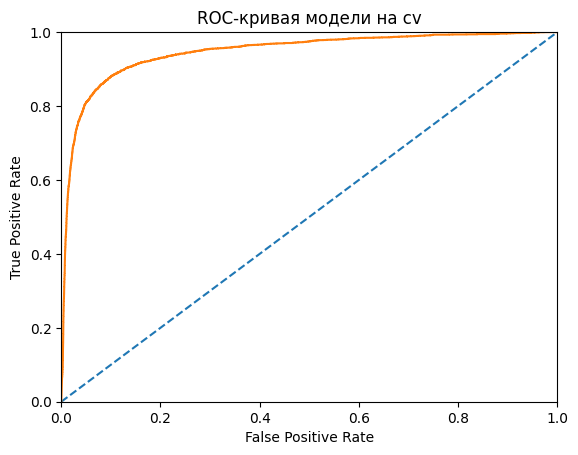

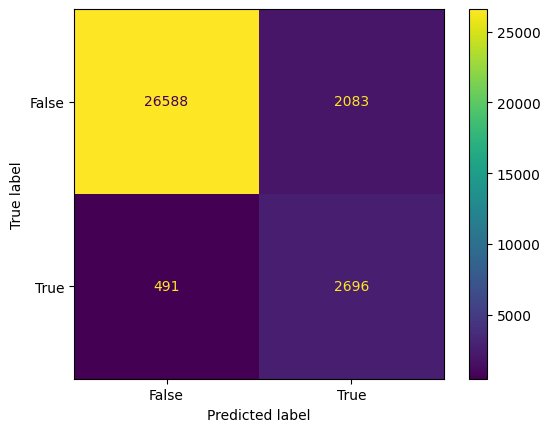

|best_roc_auc|: 0.9456555873612024
CPU times: total: 16.5 s
Wall time: 2min 2s


In [18]:
%%time
# cv
sgdc_count_cv = SGDClassifier(loss="log_loss", random_state = RANDOM_STATE, class_weight='balanced')
param_sgdc_count_cv = {
    'learning_rate': ['optimal', 'constant', 'invscaling'],
    'eta0' : [0.01, 0.05, 0.1, 0.2, 0.3, 0.5],
    'max_iter' : np.arange(5,11),
   }
sgdc_count_cv_f1, sgdc_fit_time_count_cv_f1, sgdc_predict_time_count_cv_f1, sgdc_count_cv_roc_auc = grid_cv(sgdc_count_cv, 
                                                                                                            param_sgdc_count_cv, 
                                                                                                            n_gramm_train, 
                                                                                                            target_train,
                                                                                                            n_gramm_valid, 
                                                                                                            target_valid)

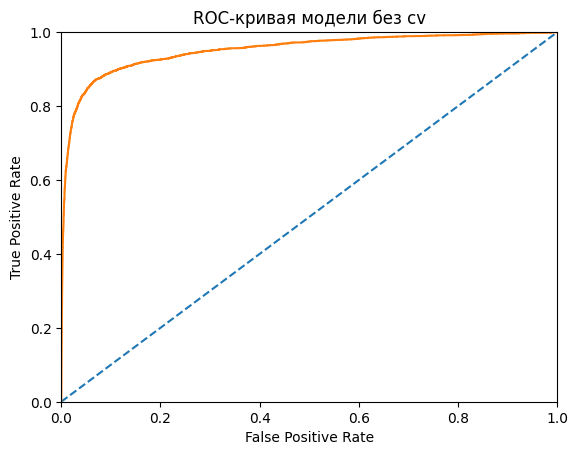

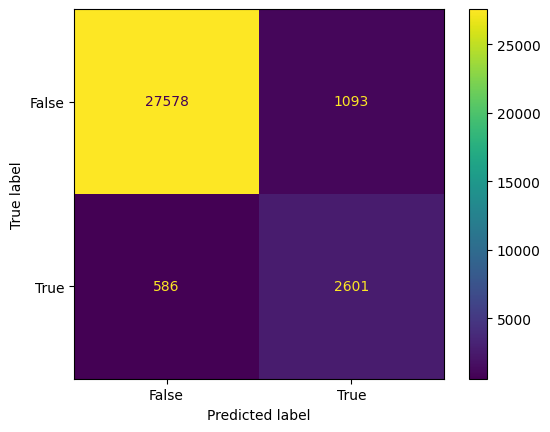

f1 модели без cv: 0.7559947682022962
ROC-AUC без cv: 0.951519744403024
recall без cv: 0.8161280200815815
precision без cv: 0.7041147807255008
CPU times: total: 16.2 s
Wall time: 9.06 s


In [19]:
%%time
# без cv
lr_count_not_cv = LogisticRegression(class_weight='balanced', random_state = RANDOM_STATE) # учитываем несбалансированность классов
lr_count_not_cv_f1, lr_count_not_cv_roc_auc  = model_not_cv(lr_count_not_cv,
                                                            n_gramm_train, 
                                                            target_train,
                                                            n_gramm_valid,
                                                            target_valid)

------
## TfidfVectorizer

-----


In [20]:
count_tf_idf = TfidfVectorizer(stop_words=stopwords)
tf_idf_features_train = count_tf_idf.fit_transform(features_train) # обучаем только на трейне
tf_idf_features_valid = count_tf_idf.transform(features_valid)
tf_idf_features_test = count_tf_idf.transform(features_test)

print('размер n-граммы на train:', tf_idf_features_train.shape)
print('размер n-граммы на valid:', tf_idf_features_valid.shape)
print('размер n-граммы на test:', tf_idf_features_test.shape)

размер n-граммы на train: (95575, 111342)
размер n-граммы на valid: (31858, 111342)
размер n-граммы на test: (31859, 111342)


____
f1
____
|best f1|: 0.7449960613976203
|best params_f1|: {}
|best_fit_time_f1|: 1.0063800811767578
|best_time_predict_f1|: 0.027049541473388672
-------------------------------------------------------
_________
roc_auc
_________


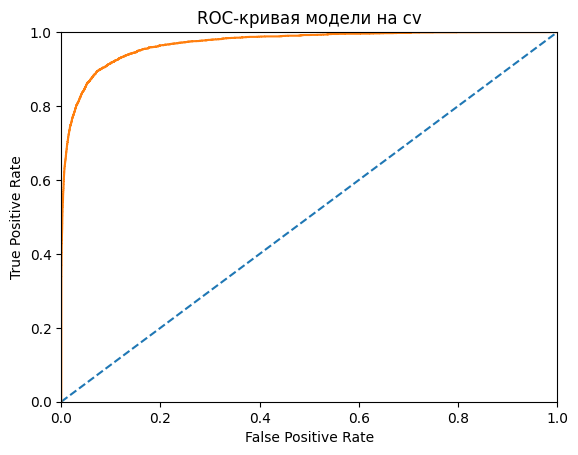

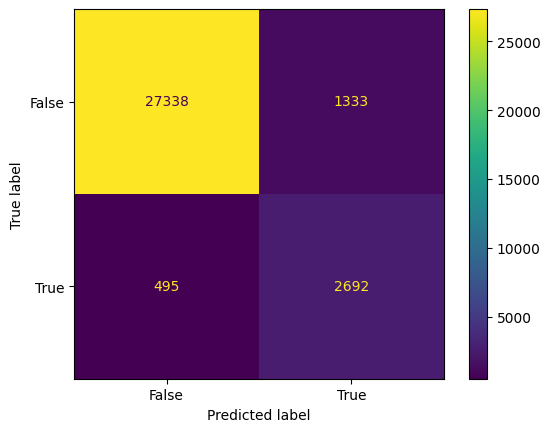

|best_roc_auc|: 0.9670976193011432
CPU times: total: 3 s
Wall time: 6.37 s


In [21]:
%%time
# cv
lr_tf_idf_cv = LogisticRegression(random_state = RANDOM_STATE, class_weight='balanced')
param_lr_tf_idf_cv = {}
lr_tf_idf_cv_f1, lr_fit_time_tf_idf_cv_f1, lr_predict_time_tf_idf_cv_f1, lr_tf_idf_cv_roc_auc = grid_cv(lr_tf_idf_cv, 
                                                                                                        param_lr_tf_idf_cv,
                                                                                                        tf_idf_features_train,
                                                                                                        target_train,
                                                                                                        tf_idf_features_valid,
                                                                                                        target_valid)

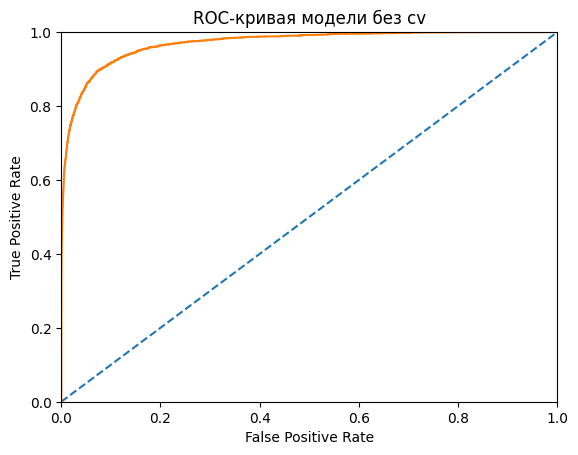

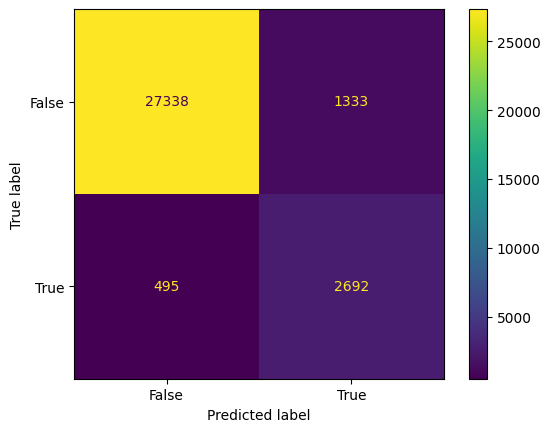

f1 модели без cv: 0.7465335551858014
ROC-AUC без cv: 0.9699159427199786
recall без cv: 0.8446815186695952
precision без cv: 0.6688198757763976
CPU times: total: 1.45 s
Wall time: 1.42 s


In [22]:
%%time
# без cv
lr_tf_idf_not_cv = LogisticRegression(class_weight='balanced', random_state = RANDOM_STATE) #учитываем несбалансированность классов
lr_tf_idf_not_cv_f1, lr_tf_idf_not_cv_roc_auc = model_not_cv(lr_tf_idf_not_cv,
                                                             tf_idf_features_train,
                                                             target_train, 
                                                             tf_idf_features_valid, 
                                                             target_valid)

____
f1
____
|best f1|: 0.7207673424162634
|best params_f1|: {'eta0': 0.01, 'learning_rate': 'optimal', 'max_iter': 9}
|best_fit_time_f1|: 0.6880440711975098
|best_time_predict_f1|: 0.040044148763020836
-------------------------------------------------------
_________
roc_auc
_________


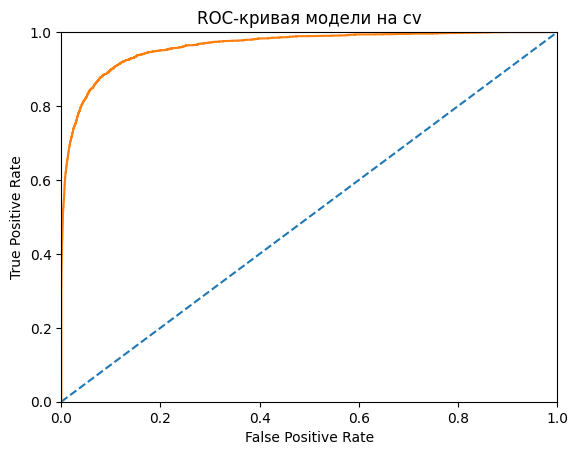

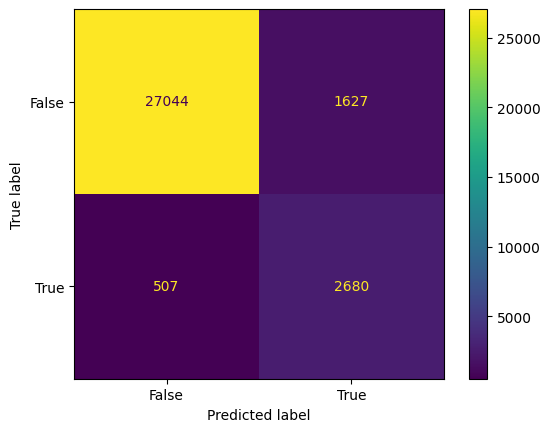

|best_roc_auc|: 0.9609390337213832
CPU times: total: 16 s
Wall time: 1min 50s


In [23]:
%%time
# cv
sgdc_tf_idf_cv = SGDClassifier(loss="log_loss", random_state = RANDOM_STATE, class_weight='balanced')
param_sgdc_tf_idf_cv = {
    'learning_rate': ['optimal', 'constant', 'invscaling'],
    'eta0' : [0.01, 0.05, 0.1, 0.2, 0.3, 0.5],
    'max_iter' : np.arange(5,11),
   }
sgdc_tf_idf_cv_f1, sgdc_fit_time_tf_idf_cv_f1, sgdc_predict_time_tf_idf_cv_f1, sgdc_tf_idf_cv_roc_auc = grid_cv(sgdc_tf_idf_cv,
                                                                                                                param_sgdc_tf_idf_cv,
                                                                                                                tf_idf_features_train,
                                                                                                                target_train, 
                                                                                                                tf_idf_features_valid,
                                                                                                                target_valid)

------

## DistilBERT

----

[DistilBERT обрабатывает предложения и передает извлеченную им информацию в следующую модель. DistilBERT представляет собой уменьшенную версию BERT'а, разработанную и выложенную в отрытый доступ группой разработчиков HuggingFace. Она быстрее и легче своего старшего собрата, но при этом вполне сравнима в результативности.](https://habr.com/ru/post/498144/)

In [24]:
# возьмем 1000 строк из выборки, чтобы модель быстрее обучилась
batch_1000, _ = train_test_split(data, train_size=1000, stratify=data['toxic'])

In [25]:
# загрузим предобученную модели DistilBERT и токенизатор
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

In [26]:
# ограничим длину очищенного текста до 512, так как этого требует модель
batch_1000['text_clean'] = batch_1000['text_clean'].str[:512]

# токенизация очищенного текста 
tokenized = batch_1000['text_clean'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
tokenized

65909     [101, 5421, 8562, 2005, 1996, 8562, 13050, 213...
138293    [101, 2672, 2619, 2066, 2198, 2210, 2064, 2272...
2730      [101, 3431, 2000, 2023, 3931, 2330, 6594, 2144...
70863     [101, 7929, 1045, 2097, 2202, 2729, 2055, 2009...
54128     [101, 2151, 6691, 2081, 2007, 2023, 5310, 8720...
                                ...                        
135862    [101, 2065, 2026, 3638, 4240, 2033, 11178, 199...
58282     [101, 12997, 1045, 1049, 2469, 2017, 2031, 319...
42593     [101, 1045, 2572, 2975, 2023, 3931, 2085, 2004...
85060     [101, 10930, 28194, 1055, 2039, 2064, 2017, 35...
143831             [101, 3531, 2131, 2125, 2009, 2525, 102]
Name: text_clean, Length: 1000, dtype: object

In [27]:
# приведет векторы к одному размеру, к коротким векторам добавим нули
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

attention_mask = np.where(padded != 0, 1, 0) # удаляем неинформативные нули
attention_mask.shape

(1000, 160)

In [28]:
batch_size = 100
embeddings = []
for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
        
        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        
        embeddings.append(batch_embeddings[0][:,0,:].numpy())

  0%|          | 0/10 [00:00<?, ?it/s]

In [29]:
# матрицa признаков
features_emb = np.concatenate(embeddings)
features_emb

array([[-0.26516435,  0.03375028,  0.04491639, ..., -0.15274258,
         0.45020747,  0.5675186 ],
       [ 0.16553067,  0.04020923,  0.04127929, ...,  0.11923642,
         0.48435923,  0.1049143 ],
       [ 0.03913496, -0.18142541,  0.03477559, ..., -0.10474089,
         0.38443226,  0.5786882 ],
       ...,
       [ 0.04054046,  0.11638688,  0.09186411, ...,  0.1298675 ,
         0.273521  ,  0.333692  ],
       [-0.02488   , -0.08846028,  0.16297425, ..., -0.14435945,
         0.2664974 ,  0.3302729 ],
       [-0.04345322, -0.03507155,  0.09402644, ..., -0.13313457,
         0.12921612,  0.26270753]], dtype=float32)

In [30]:
bert_features_train, bert_features_valid, bert_target_train, bert_target_valid = train_test_split(features_emb,
                                                                                                batch_1000['toxic'],
                                                                                                test_size=0.4,
                                                                                                random_state= RANDOM_STATE)


bert_features_valid, bert_features_test, bert_target_valid, bert_target_test = train_test_split(bert_features_valid,
                                                                                                bert_target_valid,
                                                                                                test_size = 0.5,
                                                                                                random_state = RANDOM_STATE)

____
f1
____
|best f1|: 0.6466073407778995
|best params_f1|: {}
|best_fit_time_f1|: 0.2942674160003662
|best_time_predict_f1|: 0.020275433858235676
-------------------------------------------------------
_________
roc_auc
_________


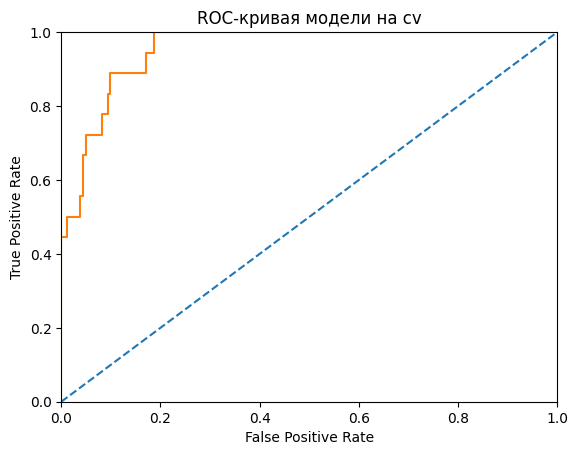

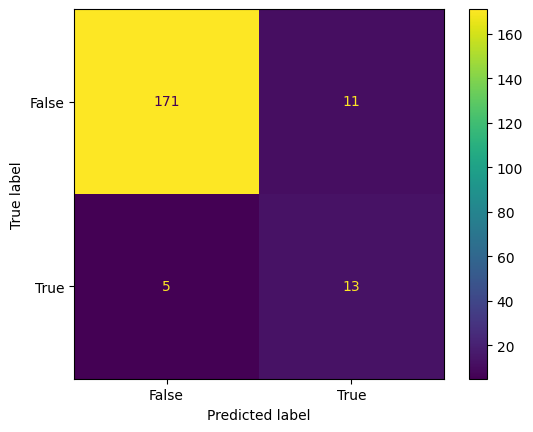

|best_roc_auc|: 0.9436284768407672
CPU times: total: 1.81 s
Wall time: 4.75 s


In [31]:
%%time
# cv
lr_bert_cv = LogisticRegression(random_state = RANDOM_STATE, class_weight='balanced')
param_lr_bert_cv = {}
lr_bert_cv_f1, lr_fit_time_bert_cv_f1, lr_predict_time_bert_cv_f1, lr_bert_cv_roc_auc = grid_cv(lr_bert_cv,
                                                                                                param_lr_bert_cv,
                                                                                                bert_features_train,
                                                                                                bert_target_train,
                                                                                                bert_features_valid,
                                                                                                bert_target_valid)

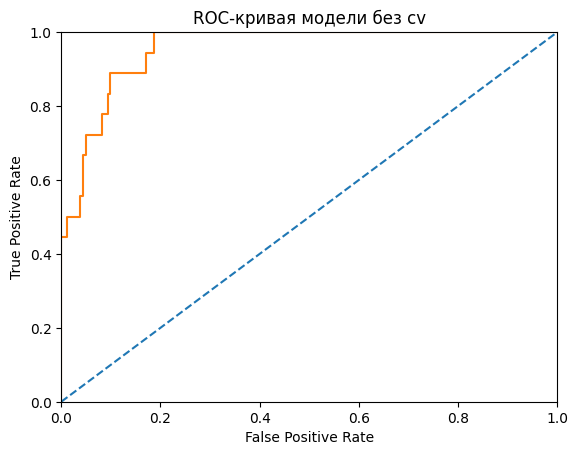

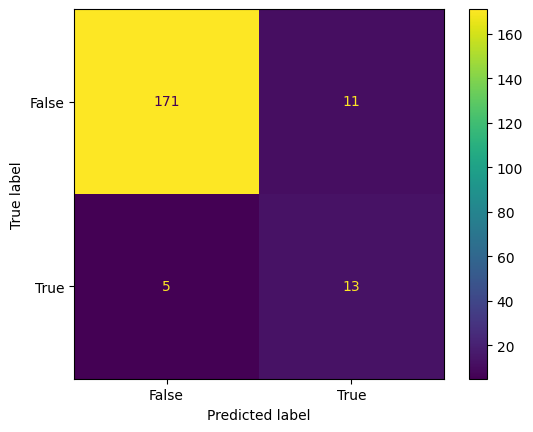

f1 модели без cv: 0.6190476190476191
ROC-AUC без cv: 0.9545177045177045
recall без cv: 0.7222222222222222
precision без cv: 0.5416666666666666
CPU times: total: 656 ms
Wall time: 645 ms


In [32]:
%%time
# без cv
lr_bert_not_cv = LogisticRegression(class_weight='balanced', random_state = RANDOM_STATE) # учитываем несбалансированность классов
lr_bert_not_cv_f1, lr_bert_not_cv_roc_auc  = model_not_cv(lr_bert_not_cv,
                                                          bert_features_train,
                                                          bert_target_train, 
                                                          bert_features_valid, 
                                                          bert_target_valid)

____
f1
____
|best f1|: 0.7134303901178547
|best params_f1|: {'eta0': 0.1, 'learning_rate': 'constant', 'max_iter': 8}
|best_fit_time_f1|: 0.03129386901855469
|best_time_predict_f1|: 0.009240309397379557
-------------------------------------------------------
_________
roc_auc
_________


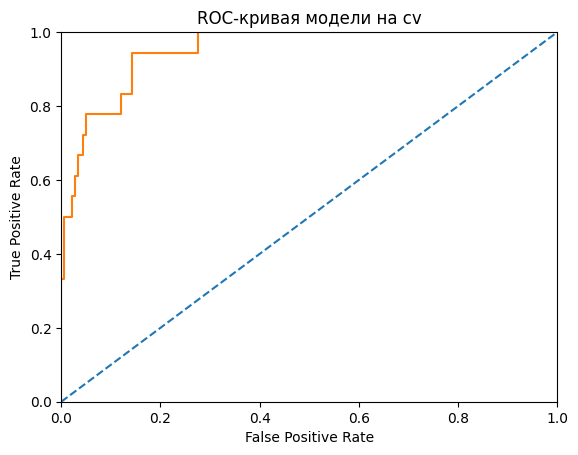

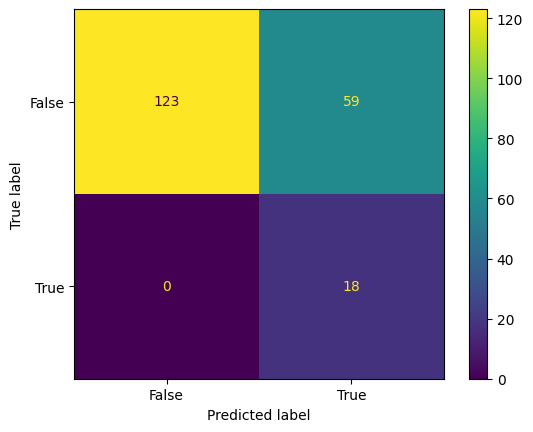

|best_roc_auc|: 0.9560383967367208
CPU times: total: 1.11 s
Wall time: 5.75 s


In [33]:
%%time
# cv
sgdc_bert_cv = SGDClassifier(loss="log_loss", random_state = RANDOM_STATE, class_weight='balanced')
param_sgdc_bert_cv = {
    'learning_rate': ['optimal', 'constant', 'invscaling'],
    'eta0' : [0.01, 0.05, 0.1, 0.2, 0.3, 0.5],
    'max_iter' : np.arange(5,11),
   }
sgdc_bert_cv_f1, sgdc_fit_time_bert_cv_f1, sgdc_predict_time_bert_cv_f1, sgdc_bert_cv_roc_auc = grid_cv(sgdc_bert_cv,
                                                                                                        param_sgdc_bert_cv,
                                                                                                        bert_features_train,
                                                                                                        bert_target_train, 
                                                                                                        bert_features_valid, 
                                                                                                        bert_target_valid)

----
## Анализ

---

In [34]:
table_count_vect = {
    'Model': ['LogReg cv', 
              'LogReg not cv', 
              'SGDC'],
    
    'F1': [lr_count_cv_f1,
           lr_count_not_cv_f1,
           sgdc_count_cv_f1],
    'Подходит': [lr_count_cv_f1> 0.75,
                lr_count_not_cv_f1>0.75,
                sgdc_count_cv_f1> 0.75],
    
    'ROC_AUC': [lr_count_cv_roc_auc,
                lr_count_not_cv_roc_auc,
                sgdc_count_cv_roc_auc],
    
    'время на fit f1 в сек': [lr_fit_time_count_cv_f1,
                              'x',
                             sgdc_fit_time_count_cv_f1],
    
    'время на predict f1 в сек':[lr_predict_time_count_cv_f1,
                                 'x',
                                sgdc_predict_time_count_cv_f1]}

table_scan_count_vect = pd.DataFrame(data = table_count_vect)
print('________________________________________________________________________________________')
print('                                 CountVectorizer')
print('________________________________________________________________________________________')
display(table_scan_count_vect)

print('-----------------------------------------------------------------------------------------')

table_tf_idf_vect = {
    'Model': ['LogReg cv', 
              'LogReg not cv', 
              'SGDC'],
    
    'F1': [lr_tf_idf_cv_f1,
           lr_tf_idf_not_cv_f1,
           sgdc_tf_idf_cv_f1],
    
    'Подходит': [lr_tf_idf_cv_f1>0.75,
                lr_tf_idf_not_cv_f1>0.75,
                sgdc_tf_idf_cv_f1>0.75],
    
    'ROC_AUC': [lr_tf_idf_cv_roc_auc,
                lr_tf_idf_not_cv_roc_auc,
                sgdc_tf_idf_cv_roc_auc],
    
    'время на fit f1 в сек': [lr_fit_time_tf_idf_cv_f1,
                              'x',
                             sgdc_fit_time_tf_idf_cv_f1],
    
    'время на predict f1 в сек':[lr_predict_time_tf_idf_cv_f1,
                                 'x',
                                sgdc_predict_time_tf_idf_cv_f1]}

table_scan_tf_idf_vect = pd.DataFrame(data = table_tf_idf_vect)
print('________________________________________________________________________________________')
print('                                  TfidfVectorizer')
print('________________________________________________________________________________________')
display(table_scan_tf_idf_vect)

print('-----------------------------------------------------------------------------------------')

table_bert = {
    'Model': ['LogReg cv', 
              'LogReg not cv', 
              'SGDC'],
    
    'F1': [lr_bert_cv_f1,
           lr_bert_not_cv_f1,
           sgdc_bert_cv_f1],
    'Подходит': [lr_bert_cv_f1>0.75,
                lr_bert_not_cv_f1>0.75,
                sgdc_bert_cv_f1>0.75],
    
    'ROC_AUC': [lr_bert_cv_roc_auc,
                lr_bert_not_cv_roc_auc,
                sgdc_bert_cv_roc_auc],
    
    'время на fit f1 в сек': [lr_fit_time_bert_cv_f1,
                              'x',
                             sgdc_fit_time_bert_cv_f1],
    
    'время на predict f1 в сек':[lr_predict_time_bert_cv_f1,
                                 'x',
                                sgdc_predict_time_bert_cv_f1]}

table_scan_bert = pd.DataFrame(data = table_bert)
print('________________________________________________________________________________________')
print('                                DistilBERT part')
print('________________________________________________________________________________________')
display(table_scan_bert)

________________________________________________________________________________________
                                 CountVectorizer
________________________________________________________________________________________


,Model,F1,Подходит,ROC_AUC,время на fit f1 в сек,время на predict f1 в сек
0,LogReg cv,0.755241,True,0.947770,3.790708,0.034496
1,LogReg not cv,0.755995,True,0.951520,x,x
2,SGDC,0.705480,False,0.945656,0.549389,0.052161


-----------------------------------------------------------------------------------------
________________________________________________________________________________________
                                  TfidfVectorizer
________________________________________________________________________________________


,Model,F1,Подходит,ROC_AUC,время на fit f1 в сек,время на predict f1 в сек
0,LogReg cv,0.744996,False,0.967098,1.00638,0.02705
1,LogReg not cv,0.746534,False,0.969916,x,x
2,SGDC,0.720767,False,0.960939,0.688044,0.040044


-----------------------------------------------------------------------------------------
________________________________________________________________________________________
                                DistilBERT part
________________________________________________________________________________________


,Model,F1,Подходит,ROC_AUC,время на fit f1 в сек,время на predict f1 в сек
0,LogReg cv,0.646607,False,0.943628,0.294267,0.020275
1,LogReg not cv,0.619048,False,0.954518,x,x
2,SGDC,0.713430,False,0.956038,0.031294,0.00924


> Мешок слов и TF-IDF не учитывает контекст и свойства слов при переведе в векторы, поэтому их метрики выше, чем у BERT.

> К тому же для BERT была взята маленькая часть из всей выборки, чтобы в учебном режиме не приходилось долго ждать, это все следует учесть. 

> Будем считать, что модель LR на CountVectorizer `e наилучшая

Про особенности моделей:
* https://towardsdatascience.com/9-best-machine-learning-models-for-beginners-2bcd8386774d

----
## Тестирование лучшей модели

----

0.7667233560090703

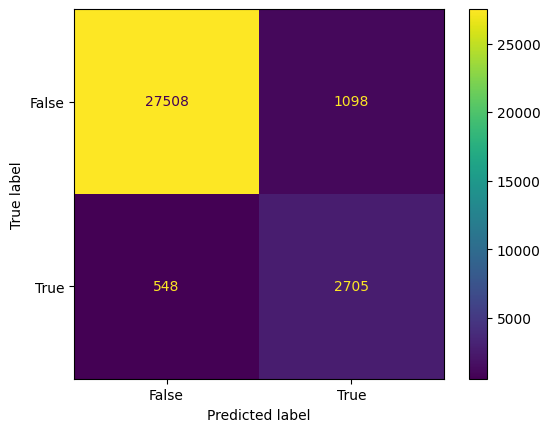

In [35]:
model_best = LogisticRegression(class_weight='balanced', random_state = RANDOM_STATE)
model_best.fit(n_gramm_train, target_train)
f1_best_model = f1_score(model_best.predict(n_gramm_test), target_test)
display(f1_best_model)

confusion_matrix = metrics.confusion_matrix(target_test, model_best.predict(n_gramm_test)) # Матрица предсказаний
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True]) 
cm_display.plot()
plt.show()

-----

# Выводы

-----

1. Проанализировали данные: наблюдается дисбаланс классов. При обучении модели это учли.
2. Проверили несколько векторизаторов: CountVectorizer и TfidfVectorizer.
3. Была изучена двунаправленной нейронная сеть-кодировщик: DistilBERT (она есть в открытом доступе в отличие от BERT)
4. Были обучены модели с кросс-валидацией и без нее.
5. Были обучены следующие модели:
* LogisticRegression (с cv и без cv)
* бустинговая модель SGDC
6. На TfidfVectorizer`е метрика f1 чуть меньше, но roc_auc выше
7. Лучшей моделью является LogisticRegression с cv на CountVectorizer`е 
* но следует учитывать, что в рамках обучения BERT не была полностью изучена
8. При тестировании лучшей модели метрика f1 оказалась больше 0.75

# Pipeline

In [36]:
# cv
# PIPEline
def grid_cv_pipe(pipe, param_grid, x_train, y_train):
    print('____')
    print('f1')
    print('____')
    grid_f1 = GridSearchCV(
        pipe,
        param_grid,
        scoring='f1', 
        n_jobs= -1,
        cv = 3) # так как мы разделяли на 3 выборки, то сделем cv меньше
    grid_f1.fit(x_train, y_train)
    
    print('|best f1|:', grid_f1.best_score_) # лучшее значение f1 на кросс-валидации
    print('|best params_f1|:', grid_f1.best_params_)  # лучшие гиперпараметры
    print('|best_fit_time_f1|:', grid_f1.refit_time_) # время лучшей модели на fit
    
    cv_result_best_f1 = pd.DataFrame(grid_f1.cv_results_).iloc[grid_f1.best_index_] # здесь хранится таблица со всеми лучшими результатами grid`а
    print('|best_time_predict_f1|:', cv_result_best_f1['mean_score_time']) # время лучшей модели на predict()
    
    print('-------------------------------------------------------')
    
    print('_________')
    print('roc_auc')
    print('_________')
    grid_roc_auc = GridSearchCV(
        pipe,
        param_grid,
        scoring='roc_auc',  # учитываем несбалансированность классов и используем ovr, так как он чувствителен к дисбалансу
        n_jobs= -1,
        cv = 3) # так как мы разделяли на 3 выборки, то сделем cv меньше
    grid_roc_auc.fit(x_train, y_train)
    
    
    predictions = grid_roc_auc.predict(x_train)
    probabilities = grid_roc_auc.predict_proba(x_train)
    probabilities_one = probabilities[:, 1]
    fpr, tpr, thresholds = roc_curve(y_train, probabilities_one)
    plt.figure()
    # ROC-кривая случайной модели (выглядит как прямая)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(fpr,tpr)
    plt.xlim([0.0, 1.0]) # устанавливаем границы осей от 0 до 1
    plt.ylim([0.0, 1.0]) # устанавливаем границы осей от 0 до 1
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая модели на cv')
    plt.show()
    
    
    confusion_matrix = metrics.confusion_matrix(y_train, predictions) # Матрица предсказаний
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True]) 
    cm_display.plot()
    plt.show() 
    
    print('|best_roc_auc|:', grid_roc_auc.best_score_) # значение roc-auc на cv
   
    return grid_f1.best_score_, grid_f1.refit_time_, cv_result_best_f1['mean_score_time'], grid_roc_auc.best_score_

CPU times: total: 0 ns
Wall time: 0 ns
____
f1
____
|best f1|: 0.6849356206897174
|best params_f1|: {'clf__eta0': 0.01, 'clf__learning_rate': 'optimal', 'clf__max_iter': 6}
|best_fit_time_f1|: 7.160284519195557
|best_time_predict_f1|: 3.8829874992370605
-------------------------------------------------------
_________
roc_auc
_________


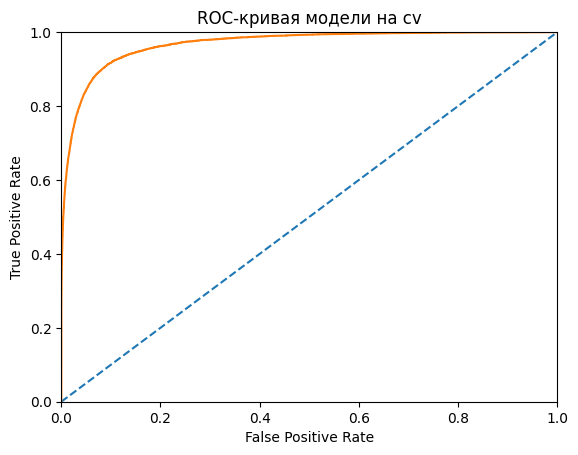

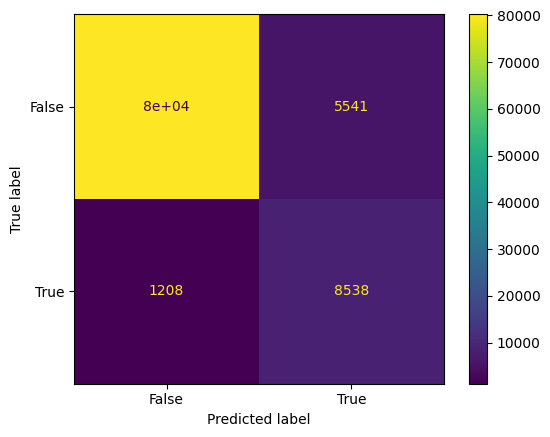

|best_roc_auc|: 0.9594296751957582


In [37]:
%time
sgdc_count_cv = SGDClassifier(loss="log_loss", random_state = RANDOM_STATE, class_weight='balanced')

pipeline = Pipeline([
           ('vect', TfidfVectorizer()),
           ('clf', sgdc_count_cv)])

param_sgdc_count_cv =[{
    'clf__learning_rate': ['optimal', 'constant', 'invscaling'],
    'clf__eta0' : [0.01, 0.05, 0.1, 0.2, 0.3, 0.5],
    'clf__max_iter' : np.arange(5,11),}]
sgdc_count_cv_f1, sgdc_fit_time_count_cv_f1, sgdc_predict_time_count_cv_f1, sgdc_count_cv_roc_auc = grid_cv_pipe(pipeline,
                                                                                                                 param_sgdc_count_cv,
                                                                                                                 features_train,
                                                                                                                 target_train)

In [38]:
%time
from sklearn import svm
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=6)
classifier = svm.SVC(kernel="linear", probability=True, random_state= RANDOM_STATE)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(6, 6))
for fold, (train, test) in enumerate(cv.split(n_gramm_test, target_test)):
    classifier.fit(n_gramm_train, target_train)
    viz = RocCurveDisplay.from_estimator(
        classifier,
        n_gramm_test,
        target_test,
        name=f"ROC fold {fold}",
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
ax.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability\n(Positive label '{target_names[1]}')",
)
ax.axis("square")
ax.legend(loc="lower right")
plt.show()